# Spark Project

Spark project

author(s): Hao Ye UID: 23376; Pierre-Louis Landouzi

In [91]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql import functions
from pyspark.sql.functions import udf, isnan, when, count, col, lit, expr, desc, mean, date_sub, next_day, year, date_format, pandas_udf, PandasUDFType
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import datetime

In [143]:
spark_application_name = "Spark_Project"
spark = (SparkSession.builder.appName(spark_application_name).getOrCreate())
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [3]:
stocks_path = 'stocks_data/MICROSOFT.csv'
another_sck_path = 'stocks_data/AMAZON.csv'

### Read Data function

In [4]:
def get_data(path, schema, header=True, delimiter=';'):
    """Lire les données à partir d'un path.

    Parameters
    ----------
    path : string
        Le chemin du fichier
    schema : StructType
        Le schema appliqué sur le dataframe
    header: bool
        Le boolean qui indique l'utilisation de la première ligne comme noms de colonnes. True par défaut
    delimiter: 
        Définit un séparateur pour chaque champ et chaque valeur. ; par défaut
    Returns
    -------
    DataFrame
        Le DataFrame du fichier
    """
    
    extension = path.split('.')[-1]
    if (extension == "csv"):
        df = spark.read.csv(path, schema, header=header, sep=delimiter)
    elif (extension == 'json'):
        df = spark.read.json(path, schema)
    else:
        # join all csv in a folder
        df = spark.read.csv(path, schema, header=header, sep=delimiter)
    return df


In [5]:
# Define schema
stocksColumns = [StructField("Date",TimestampType()), StructField("High",DoubleType()), 
              StructField("Low",DoubleType()), StructField("Open",DoubleType()),
              StructField("Close",DoubleType()), StructField("Volume", DoubleType()), 
              StructField("Adj Close",DoubleType()), StructField("company_name", StringType())]

stocksSchema = StructType(stocksColumns)


df = get_data(stocks_path, stocksSchema, delimiter=',')
df.show()

+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+
|               Date|              High|               Low|              Open|             Close|   Volume|         Adj Close|company_name|
+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+
|2017-01-03 00:00:00| 62.84000015258789|62.130001068115234|62.790000915527344| 62.58000183105469|2.06941E7| 58.67324447631836|   MICROSOFT|
|2017-01-04 00:00:00|             62.75|62.119998931884766| 62.47999954223633| 62.29999923706055|  2.134E7| 58.41072463989258|   MICROSOFT|
|2017-01-05 00:00:00| 62.65999984741211|62.029998779296875|62.189998626708984| 62.29999923706055| 2.4876E7| 58.41072463989258|   MICROSOFT|
|2017-01-06 00:00:00|63.150001525878906|62.040000915527344| 62.29999923706055| 62.84000015258789|1.99229E7|58.917015075683594|   MICROSOFT|
|2017-01-09 00:00:00

In [6]:
def show_first_rows(df):
    """Afficher les 40 permières lignes d'un dataframe.

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    df.show(40)

In [7]:
def show_last_rows(df):
    """Afficher les 40 dernières lignes d'un dataframe.

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    spark.createDataFrame(df.tail(40)).show()

In [8]:
def get_num_rows(df):
    """Afficher le nombres de lignes d'un dataframe.

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    print('Number of rows: ' + str(df.count()))

In [9]:
def days_to_period(nb_days):
    if (nb_days > 365):
        return 'year'
    elif (nb_days > 28):
        return 'month'
    elif (nb_days > 7):
        return "week"
    else:
        return 'day'

def get_period(df):
    """Afficher la période d'un dataframe

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    df = df.select("Date")
    # Create a by 1 shift column 
    my_window = Window.partitionBy().orderBy("Date")
    # Assign on prev_date column
    df = df.withColumn("prev_date", functions.lag(df.Date).over(my_window))
    # Compute diff between Date column and prev_date column and save on delta column
    df = df.withColumn("delta", functions.when(functions.isnull(df['Date'].cast("long") - df['prev_date'].cast('long')), 0)
                              .otherwise(df['Date'].cast('long') - df['prev_date'].cast('long')))
    # Compute diff in days
    df = df.withColumn("delta_days" , df['delta']/(24*3600))
    # Transform function to udf, just like .apply in pandas
    udf_days_to_period = udf(lambda x:days_to_period(x),StringType())
    
    # Compute the period according to days
    df = df.withColumn("period", udf_days_to_period(df['delta_days']))
    
    df = df.groupBy("period").count()
    df = df.sort(df["count"].desc())
    X = df.collect()[0][0]
    print('The period is a ' + str(X) + ' period')

In [10]:
get_period(df)

22/05/20 15:07:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 15:07:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


The period is a day period


In [11]:
def get_stats(df):
    """Afficher les statistiques de base d'un dataframe

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    df.describe().show()

In [12]:
get_stats(df)

+-------+------------------+------------------+------------------+------------------+--------------------+------------------+------------+
|summary|              High|               Low|              Open|             Close|              Volume|         Adj Close|company_name|
+-------+------------------+------------------+------------------+------------------+--------------------+------------------+------------+
|  count|               987|               987|               987|               987|                 987|               987|         987|
|   mean|123.52858665334901|121.02308006634466|122.32611970601957|122.34503256924367|2.9104952561296858E7|119.77032003045203|        null|
| stddev| 46.40416482581066|45.038031013567725| 45.73307377448831| 45.74600811823214|1.3627194702253582E7| 46.76978863281242|        null|
|    min| 62.65999984741211| 61.95000076293945|62.189998626708984| 62.29999923706055|           6486678.0| 58.41072463989258|   MICROSOFT|
|    max|232.86000061035156

In [13]:
def get_na(df):
    """Afficher le nombre de valeur manquante pour chaque colonne

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    # Cast timestamp to long for check null
    df2 = df.withColumn("Date_long", df['Date'].cast('long'))
    df2 = df2.drop(df2['Date'])
    df2 = df2.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df2.columns])
    df2.show()

In [14]:
get_na(df)

+----+---+----+-----+------+---------+------------+---------+
|High|Low|Open|Close|Volume|Adj Close|company_name|Date_long|
+----+---+----+-----+------+---------+------------+---------+
|   0|  0|   0|    0|     0|        0|           0|        0|
+----+---+----+-----+------+---------+------------+---------+



In [15]:
def plot_corr(df):
    """Dessiner la matrice de corrélation

    Parameters
    ----------
    df : DataFrame
    
    Returns
    -------
        Void
    """
    df = df.drop(*('Date', 'company_name'))
    columns = df.columns
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=columns, 
                            outputCol=vector_col)
    myGraph_vector = assembler.transform(df).select(vector_col)
    
    matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
    corrmatrix = matrix.toArray().tolist()

    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+columns)
    ax.set_yticklabels(['']+columns)
    cax=ax.matshow(corrmatrix,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

22/05/20 15:07:50 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/20 15:07:50 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/opt/homebrew/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/var/folders/20/t1flkcns5419tjpzt_pg4vv40000gn/T/ipykernel_4136/2972400243.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+columns)
/var/folders/20/t1flkcns5419tjpzt_pg4vv40000gn/T/ipykernel_4136/2972400243.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+columns)


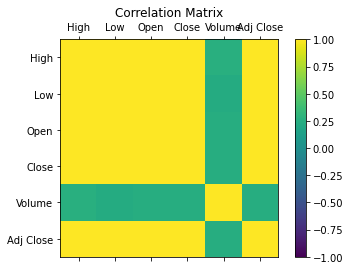

In [16]:
plot_corr(df)

In [17]:
def get_period_avg(df, period='week'):
    """Avoir la moyenne d'une period

    Parameters
    ----------
    df : DataFrame
    
    period : string
        la period pour la moyenne, par défaut week
    Returns
    -------
        DataFrame
    """
    
    df = df.select('Date', 'Open', 'Close')
    if (period == 'week'):
        df = df.withColumn("week_strt_day",date_sub(next_day(col("Date"),"sunday"),7)) \
               .groupBy("week_strt_day") \
                .agg(mean("Open").alias("weekly_avg_open"), mean("Close").alias("weekly_avg_open")) \
               .orderBy("week_strt_day")
    elif (period == 'month'):
        df = df.withColumn("month", date_format(col('Date'), 'yyyy/MM/1')) \
               .groupBy("month") \
                .agg(mean("Open").alias("monthly_avg_open"), mean("Close").alias('monthly_avg_close'))\
               .orderBy('month')
    elif (period == 'year'):
        df = df.withColumn("year", year(col('Date'))) \
               .groupBy("year") \
                .agg(mean("Open").alias("annualy_avg_open"), mean("Close").alias('annualy_avg_close'))\
               .orderBy('year')
    else:
        raise ValueError("Incorrect period format, expected week, month or year")
        
    # Maybe plot a graph ?
    return df

In [18]:
df_avg = get_period_avg(df, 'year')
df_avg.show()

+----+------------------+------------------+
|year|  annualy_avg_open| annualy_avg_close|
+----+------------------+------------------+
|2017| 71.95430287516925| 71.98402421502954|
|2018|101.12235092831799|101.03398411967365|
|2019|130.33904787093874|130.38202400813026|
|2020|190.76480678836674| 190.8616180419922|
+----+------------------+------------------+



In [19]:
def get_evolution(df, period='day'):
    """Avoir l'évolution du prix 

    Parameters
    ----------
    df : DataFrame
    
    period : string
        l'échelle de l'évolution, par défaut day
    Returns
    -------
        DataFrame
    """
    w = Window.partitionBy().orderBy("Date")
    if (period == 'day'): 
        df_prev = df.withColumn('prev_high', functions.lag(df['High']).over(w)) \
                    .withColumn('prev_low', functions.lag(df['Low']).over(w)) \
                    .withColumn('prev_open', functions.lag(df['Open']).over(w)) \
                    .withColumn('prev_close', functions.lag(df['Close']).over(w))
    
    elif (period == 'month'):
        df_group_by_month = df.select('Date', 'High', 'Low', 'Open', 'Close') \
                              .withColumn("Date", date_format(col('Date'), 'yyyy/MM/1')) \
                              .groupBy("Date")\
                              .agg(functions.sum("High").alias("High"), 
                                   functions.sum("Low").alias("Low"), 
                                   functions.sum("Open").alias("Open"), 
                                   functions.sum("Close").alias("Close"))\
                              .orderBy('Date')
        
        df_prev = df_group_by_month.withColumn('prev_high', functions.lag(df_group_by_month['High']).over(w)) \
                    .withColumn('prev_low', functions.lag(df_group_by_month['Low']).over(w)) \
                    .withColumn('prev_open', functions.lag(df_group_by_month['Open']).over(w)) \
                    .withColumn('prev_close', functions.lag(df_group_by_month['Close']).over(w))
    else:
        raise ValueError("Incorrect period format, expected day, month")
        
    result_df = df_prev.withColumn('delta_high', df_prev['High'] - df_prev['prev_high']) \
                   .withColumn('delta_low', df_prev['Low'] - df_prev['prev_low']) \
                   .withColumn('delta_open', df_prev['Open'] - df_prev['prev_open']) \
                   .withColumn('delta_close', df_prev['Close'] - df_prev['prev_close']) \
                   .select('Date', 'delta_high', 'delta_low', 'delta_open', 'delta_close')
    
    return result_df

In [20]:
df_evol = get_evolution(df, 'month')
df_evol.show()

22/05/20 15:07:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 15:07:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 15:07:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+---------+-------------------+-------------------+-------------------+-------------------+
|     Date|         delta_high|          delta_low|         delta_open|        delta_close|
+---------+-------------------+-------------------+-------------------+-------------------+
|2017/01/1|               null|               null|               null|               null|
|2017/02/1| -47.19999694824219| -43.17999267578125| -45.14999771118164|-45.679988861083984|
|2017/03/1|  275.0299873352051|  270.3399963378906| 271.02002334594727|  273.1900100708008|
|2017/04/1|-234.58000946044922|-231.86999130249023|-231.04001998901367|-234.09000396728516|
|2017/05/1|   258.760009765625| 255.37997436523438| 255.68000030517578|  258.9199981689453|
|2017/06/1| 39.709991455078125| 30.659996032714844| 38.139991760253906|  35.21998596191406|
|2017/07/1|-114.06000518798828|-107.55998992919922|-115.49000549316406|-111.18998718261719|
|2017/08/1| 235.25000762939453|  233.7400131225586| 235.58999633789062| 234.5800

22/05/20 15:07:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 15:07:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [21]:
def dailyReturn(df):
    return df.select(col("company_name"), col("Date"), expr("(Close - Open) as dailyReturn"))

In [22]:
dailyReturn(df).show()

+------------+-------------------+--------------------+
|company_name|               Date|         dailyReturn|
+------------+-------------------+--------------------+
|   MICROSOFT|2017-01-03 00:00:00|-0.20999908447265625|
|   MICROSOFT|2017-01-04 00:00:00|-0.18000030517578125|
|   MICROSOFT|2017-01-05 00:00:00|  0.1100006103515625|
|   MICROSOFT|2017-01-06 00:00:00|  0.5400009155273438|
|   MICROSOFT|2017-01-09 00:00:00|-0.11999893188476562|
|   MICROSOFT|2017-01-10 00:00:00| -0.1100006103515625|
|   MICROSOFT|2017-01-11 00:00:00|  0.5799980163574219|
|   MICROSOFT|2017-01-12 00:00:00| -0.4500007629394531|
|   MICROSOFT|2017-01-13 00:00:00|  0.0800018310546875|
|   MICROSOFT|2017-01-17 00:00:00|-0.15000152587890625|
|   MICROSOFT|2017-01-18 00:00:00| -0.1699981689453125|
|   MICROSOFT|2017-01-19 00:00:00|    0.05999755859375|
|   MICROSOFT|2017-01-20 00:00:00| 0.07000350952148438|
|   MICROSOFT|2017-01-23 00:00:00|  0.2599983215332031|
|   MICROSOFT|2017-01-24 00:00:00| 0.31999969482

In [23]:
from pyspark.sql.functions import desc, max

def bestDailyReturn(df):
    return df.select(col("company_name"), expr("(Close - Open) as dailyReturn"))\
        .groupBy(col('company_name'))\
        .agg(max('dailyReturn'))

In [24]:
bestDailyReturn(df).show()

+------------+------------------+
|company_name|  max(dailyReturn)|
+------------+------------------+
|   MICROSOFT|11.330001831054688|
+------------+------------------+



In [40]:
def averageDailyReturnByWeek(df):
    return dailyReturn(df)\
    .withColumn("Date",date_sub(next_day(col("Date"),"sunday"),7))\
    .groupBy("company_name", "Date").mean("dailyReturn")

def averageDailyReturnByMonth(df):
    return dailyReturn(df)\
    .withColumn("Date",date_format(col("Date"),"yyyy-MM"))\
    .groupBy("company_name", "Date").mean("dailyReturn")

def averageDailyReturnByYear(df):
    return dailyReturn(df)\
    .withColumn("Date",date_format(col("Date"),"yyyy"))\
    .groupBy("company_name", "Date").mean("dailyReturn")

averageDailyReturnByWeek(df).show()
averageDailyReturnByMonth(df).show()
averageDailyReturnByYear(df).show()

+------------+----------+--------------------+
|company_name|      Date|    avg(dailyReturn)|
+------------+----------+--------------------+
|   MICROSOFT|2017-01-15|-0.04749965667724...|
|   MICROSOFT|2020-02-02|                 1.3|
|   MICROSOFT|2020-03-15| -0.8639984130859375|
|   MICROSOFT|2017-06-18| 0.07200164794921875|
|   MICROSOFT|2019-11-10|  0.8420013427734375|
|   MICROSOFT|2019-09-22|  -0.705999755859375|
|   MICROSOFT|2017-07-09|   0.355999755859375|
|   MICROSOFT|2018-09-09|  0.7919998168945312|
|   MICROSOFT|2020-08-02|  0.7639984130859375|
|   MICROSOFT|2017-08-20| 0.03200225830078125|
|   MICROSOFT|2018-02-04| -0.3639984130859375|
|   MICROSOFT|2018-05-27|  0.4675006866455078|
|   MICROSOFT|2018-09-30| -0.3720001220703125|
|   MICROSOFT|2018-02-25|-0.25200042724609373|
|   MICROSOFT|2018-11-11| -0.5579986572265625|
|   MICROSOFT|2019-02-10| 0.00200042724609375|
|   MICROSOFT|2018-10-14|   -0.53800048828125|
|   MICROSOFT|2017-08-27|   0.308001708984375|
|   MICROSOFT

In [76]:
def moving_averge(df, column, moving_range=5):
    """Calcul la moyenne mobile

    Parameters
    ----------
    df : DataFrame
        
    column : string
        La colonne où on calcule la moyenne mobile
    moving_range: int
        La portée pour calculer la moyenne mobile. 5 par défaut
    delimiter: 
        Définit un séparateur pour chaque champ et chaque valeur. ; par défaut
    Returns
    -------
    DataFrame
        Le DataFrame avec la colonne moving_average
    """
    check = df.select(col(column), col(column).cast("int").isNotNull().alias("Value")).select("Value").collect()
    if_all_true = all(e for e in check)
    if (if_all_true):
        w = (Window.orderBy(functions.col("Date")).rowsBetween(-moving_range, 0))
        df = df.withColumn('moving_average', functions.mean(column).over(w))
        return df
    else: 
        raise ValueError("Selected column is not numeric type")

In [77]:
moving_averge(df, 'Open').select('Date', 'Open', 'moving_average').show()

+-------------------+------------------+------------------+
|               Date|              Open|    moving_average|
+-------------------+------------------+------------------+
|2017-01-03 00:00:00|62.790000915527344|62.790000915527344|
|2017-01-04 00:00:00| 62.47999954223633|62.635000228881836|
|2017-01-05 00:00:00|62.189998626708984| 62.48666636149088|
|2017-01-06 00:00:00| 62.29999923706055|  62.4399995803833|
|2017-01-09 00:00:00|  62.7599983215332| 62.50399932861328|
|2017-01-10 00:00:00| 62.72999954223633| 62.54166603088379|
|2017-01-11 00:00:00| 62.61000061035156| 62.51166598002116|
|2017-01-12 00:00:00|63.060001373291016| 62.60833295186361|
|2017-01-13 00:00:00|62.619998931884766|62.679999669392906|
|2017-01-17 00:00:00| 62.68000030517578|62.743333180745445|
|2017-01-18 00:00:00| 62.66999816894531|62.728333155314125|
|2017-01-19 00:00:00|  62.2400016784668|62.646666844685875|
|2017-01-20 00:00:00| 62.66999816894531| 62.65666643778483|
|2017-01-23 00:00:00| 62.70000076293945|

22/05/20 17:39:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 17:39:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 17:39:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [38]:
def corr_with(df1, df2):
    df1 = df1.select(col('Date').alias('Date1'),
                     col('Low').alias('Low-1'), 
                     col('High').alias('High-1'), 
                     col('Open').alias('Open-1'),
                     col('Close').alias('Close-1'),
                     col('Volume').alias('Volume-1'),
                     col('Adj Close').alias('Adj Close-1'))

    
    df2 = df2.select(col('Date').alias('Date2'),
                     col('Low').alias('Low-2'), 
                     col('High').alias('High-2'), 
                     col('Open').alias('Open-2'),
                     col('Close').alias('Close-2'),
                     col('Volume').alias('Volume-2'),
                     col('Adj Close').alias('Adj Close-2'))
    
    df = df1.join(df2, df1.Date1 == df2.Date2 ,how='inner').drop(*('Date1', 'Date2'))
    columns = list(df.columns)
    
    
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=columns, 
                            outputCol=vector_col)
    myGraph_vector = assembler.transform(df).select(vector_col)
     
    matrix = Correlation.corr(myGraph_vector, vector_col)
    corrmatrix = matrix.collect()[0][matrix.columns[0]].toArray()
    
    fig=plt.figure(figsize=(20,10))
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    cax=ax.matshow(corrmatrix,vmax=1,vmin=-1)
    ax.set_yticks(np.arange(len(columns), step=1), labels=columns)
    ax.set_xticks(np.arange(len(columns), step=1), labels=columns, rotation=90)
    fig.colorbar(cax)
    plt.show()

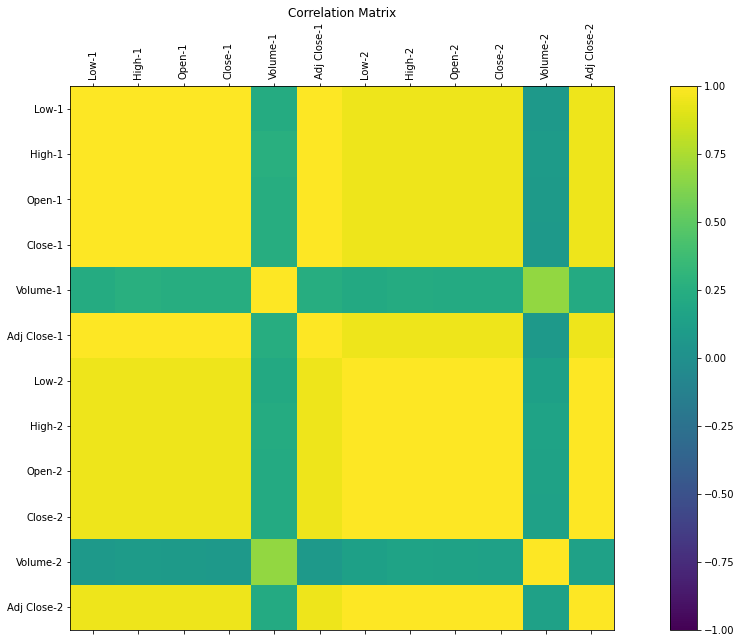

In [39]:
df2 = get_data(another_sck_path, stocksSchema, delimiter=',')
corr_with(df, df2)

In [30]:
def validate(date_text):
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect date format, should be YYYY-MM-DD")


def RoR(df, date, period):
    
    # Check date format
    validate(date)
    
    # Parse date and manage errors
    originalDate = datetime.datetime.strptime(date, "%Y-%m-%d")
    currentDate = originalDate
    
    # Parse period and manage errors
    if period == "week":
        currentDate += datetime.timedelta(days=7)  
    elif period == "month":
        currentDate += datetime.timedelta(days=30)
    elif period == "year":
        currentDate += datetime.timedelta(days=365)
    else:
        raise ValueError("Incorrect period format, expected week, month or year")
   

    tmp = df.select(col("Date"), col("Open"))
    
    # Get rows and manage errors
    originalRow = tmp.filter(col("Date") == originalDate).first()
    if(originalRow == None):
        raise ValueError("Incorrect date:", originalDate.strftime("%Y-%m-%d"))
    
    currentRow = tmp.filter(col("Date") == currentDate).first()
    if(currentRow == None):
        raise ValueError("Incorrect date:", currentDate.strftime("%Y-%m-%d"))
    
    # Get values
    originalVal = float(originalRow.__getitem__('Open'))
    currentValue = float(currentRow.__getitem__('Open'))
    
    # Return the calcul
    return (currentValue - originalVal) / originalVal * 100

In [31]:
print(RoR(df, "2017-01-03", "week"))
print(RoR(df, "2017-01-03", "month"))
print(RoR(df, "2017-01-03", "year"))

-0.09555880301982586
0.7325992638405951
37.06003552121619


In [32]:
def bestRoR(df, date, period):
    
    # Check date format
    validate(date)
    
    # Parse date and manage errors
    originalDate = datetime.datetime.strptime(date, "%Y-%m-%d")
    currentDate = originalDate
    
    # Parse period and manage errors
    if period == "month":
        currentDate += datetime.timedelta(days=30)
    elif period == "year":
        currentDate += datetime.timedelta(days=365)
    else:
        raise ValueError("Incorrect period format, expected month or year")
    
    tmp = df.select(col("Date"), col("Open"))
    
    
    # Get originalRow and manage errors
    originalRow = tmp.filter(col("Date") == originalDate).first()
    if(originalRow == None):
        raise ValueError("Incorrect date:", originalDate.strftime("%Y-%m-%d"))
        
    # Get original values
    originalVal = float(originalRow.__getitem__('Open'))
    
    
    # Get the period rows and add a column corresponding to the RoR
    tmp = tmp.where(col("Date") > originalDate) \
        .where(col("Date") <= currentDate) \
        .withColumn("originalVal", lit(originalVal)) \
        .select("Date", expr("((Open - originalVal) / originalVal * 100) as RoR"))
    
    # Get the row with the highter
    bestRoRRow = tmp.orderBy(desc("RoR")).first()
    
    
    # Return the tupple (Date, RoR)
    return (bestRoRRow.__getitem__('Date'), bestRoRRow.__getitem__('RoR'))

In [33]:
print(bestRoR(df, "2017-01-03", "month"))

(datetime.datetime(2017, 1, 30, 0, 0), 4.618572198749188)


## Insights 

In [68]:
def ROA(df, purchase_date, selling_date):
    """Return the return on assets

    Parameters
    ----------
    df : DataFrame
    
    purchase_date : string
    
    selling_date : string
    
    Returns
    -------
        DataFrame
    """
    validate(purchase_date)
    validate(selling_date)
    purchase_date = datetime.datetime.strptime(purchase_date, "%Y-%m-%d")
    selling_date = datetime.datetime.strptime(selling_date, "%Y-%m-%d")
    

    
    df = df.filter((df.Date == purchase_date) | (df.Date == selling_date))
    
    w = Window.partitionBy().orderBy("Date")
    df_prev = df.withColumn('prev_high', functions.lag(df['High']).over(w)) \
                    .withColumn('prev_low', functions.lag(df['Low']).over(w)) \
                    .withColumn('prev_open', functions.lag(df['Open']).over(w)) \
                    .withColumn('prev_close', functions.lag(df['Close']).over(w))
    
    result_df = df_prev.withColumn('roa_high', df_prev['High'] - df_prev['prev_high']) \
                   .withColumn('roa_low', df_prev['Low'] - df_prev['prev_low']) \
                   .withColumn('roa_open', df_prev['Open'] - df_prev['prev_open']) \
                   .withColumn('roa_close', df_prev['Close'] - df_prev['prev_close']) \
                   .select('roa_high', 'roa_low', 'roa_open', 'roa_close')
    
    return result_df.na.drop()

In [69]:
ROA(df, '2017-01-03', '2017-01-20').show()

+--------------------+-------------------+--------------------+-------------------+
|            roa_high|            roa_low|            roa_open|          roa_close|
+--------------------+-------------------+--------------------+-------------------+
|-0.02000045776367...|0.23999786376953125|-0.12000274658203125|0.15999984741210938|
+--------------------+-------------------+--------------------+-------------------+



22/05/20 16:49:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 16:49:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 16:49:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [189]:
def EMA(df, p=5, column='Open'):
    """Plot Exponential moving average

    Parameters
    ----------
    df : DataFrame
    
    p : int
        period, default 5
    
    columns: string
        Open or Close, default Open
    Returns
    -------
        Void
    """
    @pandas_udf('float')
    def ema(pdf):
        return pdf.ewm(com = p - 1, adjust=True, min_periods = p).mean()
    
    df = df.withColumn('ewm', ema(col(column)))
    
    Date = [val for val in df.select('Date').collect()]
    rsi = [val for val in df.select('ewm').collect()]
    ref = [val for val in df.select(column).collect()]
    
    plt.figure(figsize=(20,10))
    plt.title("Exponential moving average")
    plt.xlabel('Date') 
    plt.ylabel('price')

    plt.plot(Date, rsi, label= 'EMA with ' + str(p) + ' period')
    plt.plot(Date, ref, label= column)

    plt.legend()
    plt.show()

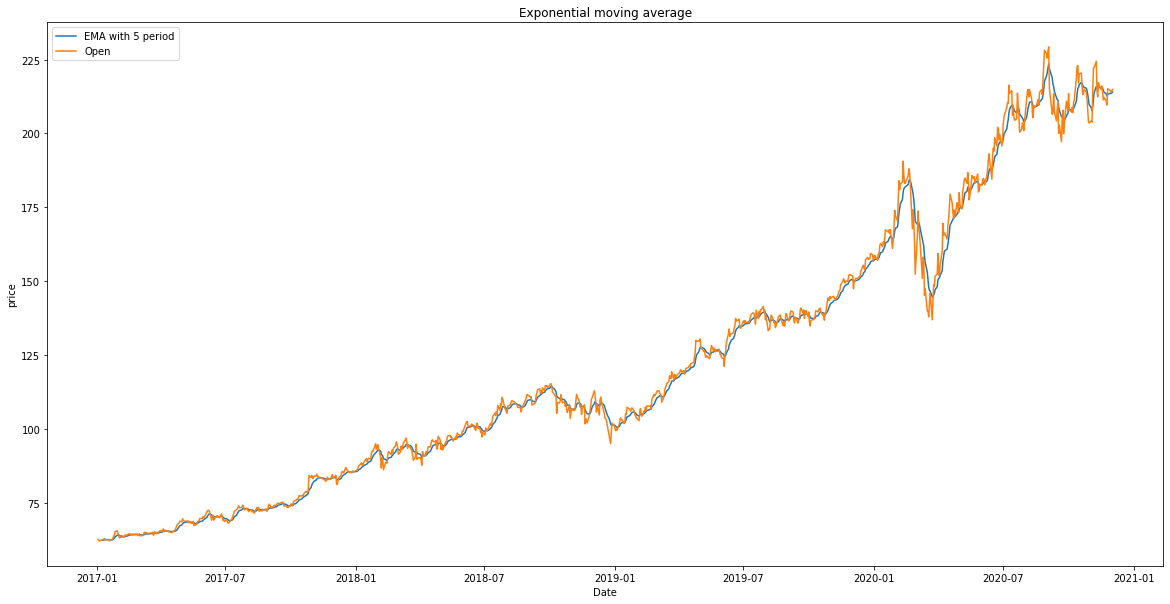

In [190]:
EMA(df)

In [176]:
def get_volume_evolution(df, period='day'):
    """Plot volume evolution

    Parameters
    ----------
    df : DataFrame
    
    period : string
        period, default day

    Returns
    -------
        Void
    """
    w = Window.partitionBy().orderBy("Date")
        
    if (period == 'day'): 
        df_prev = df.withColumn('prev_vol', functions.lag(df['Volume']).over(w))
    
    elif (period == 'month'):
        df_group_by_month = df.select('Date', 'Volume') \
                              .withColumn("Date", date_format(col('Date'), 'yyyy/MM/1')) \
                              .groupBy("Date")\
                              .agg(functions.sum("Volume").alias("Volume"))\
                              .orderBy('Date')
        
        df_prev = df_group_by_month.withColumn('prev_volume', functions.lag(df_group_by_month['volume']).over(w))
    else:
        raise ValueError("Incorrect period format, expected day, month")
        
    result_df = df_prev.withColumn('delta_volume', df_prev['Volume'] - df_prev['prev_vol']) \
                   .select('Date', 'delta_volume')
    
    '''
    Date = [val for val in result_df.select('Date').collect()]
    vol = [val for val in result_df.select('delta_volume').collect()]
    
    
    plt.figure(figsize=(20,10))
    plt.title("Volume evolution ")
    plt.xlabel('Date') 
    plt.ylabel('Stocks')

    plt.plot(Date, vol, label= 'delta_volume')

    plt.legend()
    plt.show()
    '''
    return result_df

In [178]:
get_volume_evolution(df)

22/05/20 22:12:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 22:12:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 22:12:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 22:12:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 22:12:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 22:12:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Date,delta_volume
2017-01-03 00:00:00,null
2017-01-04 00:00:00,645900.0
2017-01-05 00:00:00,3536000.0
2017-01-06 00:00:00,-4953100.0
2017-01-09 00:00:00,459800.0
2017-01-10 00:00:00,-1789700.0
2017-01-11 00:00:00,2924300.0
2017-01-12 00:00:00,-549100.0
2017-01-13 00:00:00,-1545900.0
2017-01-17 00:00:00,1241700.0


In [169]:
def rsi(df, p=14, column='Open'):
    """Plot rsi curve

    Parameters
    ----------
    df : DataFrame
    
    p : int
        period, default 14
    
    columns: string
        default Open
    Returns
    -------
        Void
    """
    w = Window.partitionBy().orderBy("Date")
    df_prev = df.withColumn('prev', functions.lag(df[column]).over(w)).select('Date', 'prev', column)
    result_df = df_prev.withColumn('gain', when(df_prev[column] - df_prev['prev'] > 0, df_prev[column] - df_prev['prev']).otherwise(0))\
                       .withColumn('loss', when(df_prev[column] - df_prev['prev'] < 0, -(df_prev[column] - df_prev['prev'])).otherwise(0))
    
    result_df = result_df.drop(*['prev'])

    w2 = (Window.orderBy(functions.col("Date")).rowsBetween(-p, 0))
    result_df = result_df.withColumn('avg_gain', functions.mean('gain').over(w2)) \
                         .withColumn('avg_loss', functions.mean('loss').over(w2))
    
    result_df = result_df.withColumn('rs', col('avg_gain') / col('avg_loss'))\
                         .withColumn('rsi', 100 - (100 / (1 + col('rs'))))
    
    Date = [val for val in result_df.select('Date').collect()]
    rsi = [val for val in result_df.select('rsi').collect()]
    ref = [val for val in result_df.select(column).collect()]
    
    
    plt.figure(figsize=(20,10))
    plt.title("RSI indicator")
    plt.xlabel('Date') 
    plt.ylabel('price')

    plt.plot(Date, rsi, label= 'RSI')
    plt.plot(Date, ref, label= column)

    plt.legend()
    plt.show()

22/05/20 22:06:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 22:06:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 22:06:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 22:06:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/20 22:06:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


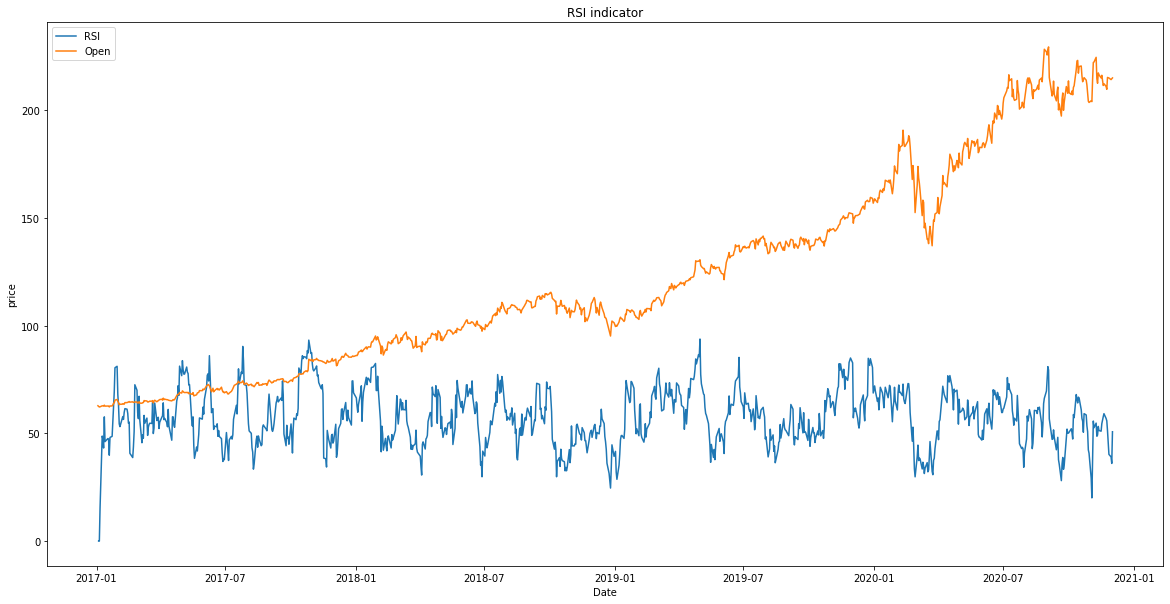

In [173]:
rsi(df)

In [219]:
def MACD(df, column='Open'):
    """Plot MACD curve

    Parameters
    ----------
    df : DataFrame
    
    columns: string
        default Open
    Returns
    -------
        Void
    """
    @pandas_udf('float')
    def pmacd(pdf):
        k = pdf.ewm(span=12, adjust=False, min_periods=12).mean()
        d = pdf.ewm(span=26, adjust=False, min_periods=26).mean()
        
        macd = k - d
        return macd
        
    macd= pmacd(col(column))
        
    df = df.withColumn('macd', macd)
        
        
    Date = [val for val in df.select('Date').collect()]
    macd_curve = [val for val in df.select('macd').collect()]
    ref = [val for val in df.select(column).collect()]

    figure, axis = plt.subplots(2, 1, figsize=(15,15))

    plt.xlabel('Date') 
    plt.ylabel('price')

    axis[0].plot(Date, ref, label= column)
    axis[0].set_title(column + ' evolution')
    axis[0].legend()
    axis[1].plot(Date, macd_curve, label= 'MACD')
    axis[1].set_title("MACD")
    axis[1].legend()

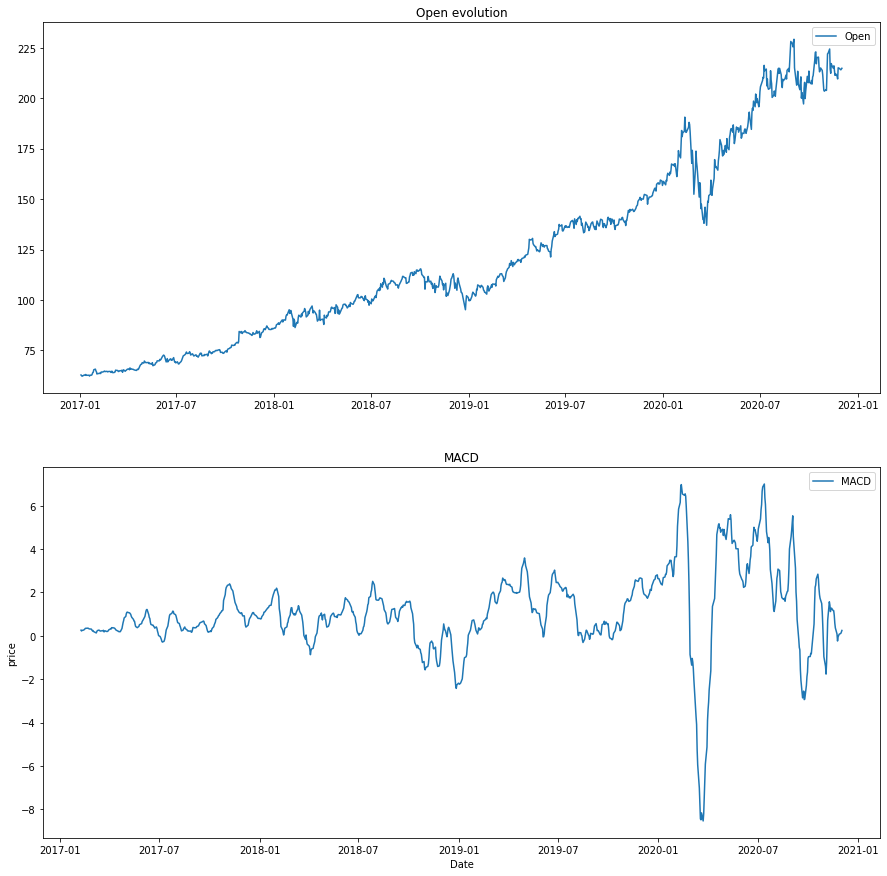

In [220]:
MACD(df)